In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

Get a high-level overview of the data we have here...

In [159]:
df = pd.read_csv("../../Datasets/spaceship-titanic/train.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


As we can see from the tables above, some of the features contain several types of values (e.g the feature "Cabin" contains three different values and doesn't follow atomic structure)...Let's do some feature engineering first

In [160]:
# Parse the "PassengerId" column from the dataset
df["PassengerGroup"] = df["PassengerId"].str.split("_").str[0]
df["PassengerNumber"] = df["PassengerId"].str.split("_").str[1]
df = df.drop("PassengerId", axis=1)

# Parse the "Cabin" feature that contains several values
df['CabinDeck'] = df['Cabin'].str.split("/").str[0]
df["CabinNum"] = df['Cabin'].str.split("/").str[1]
df['CabinSide'] = df['Cabin'].str.split("/").str[2]
df = df.drop("Cabin", axis=1)

print(df.head())

df['CryoSleep'].unique()

  HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck               Name  Transported  \
0           0.0     0.0     0.0    Maham Ofracculy        False   
1          25.0   549.0    44.0       Juanna Vines         True   
2           0.0  6715.0    49.0      Altark Susent        False   
3         371.0  3329.0   193.0       Solam Susent        False   
4         151.0   565.0     2.0  Willy Santantines         True   

  PassengerGroup PassengerNumber CabinDeck CabinNum CabinSide  
0           0001              01         B        0         P  
1           

array([False, True, nan], dtype=object)

Let's check the missing values first. As we can see, almost each column in the data set contains missing values. The following step will be training a new model which will impute missing values

In [161]:
# Get all the missing values
df.isnull().sum()

HomePlanet         201
CryoSleep          217
Destination        182
Age                179
VIP                203
RoomService        181
FoodCourt          183
ShoppingMall       208
Spa                183
VRDeck             188
Name               200
Transported          0
PassengerGroup       0
PassengerNumber      0
CabinDeck          199
CabinNum           199
CabinSide          199
dtype: int64

In [162]:
# Let's encode the categorical features first

columns_to_impute = ['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinNum', 'CabinSide', 'Destination',
                     'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

le = LabelEncoder()

# Before we start encoding the features, we need to convert the NaN values to string
nan_string = 'missing'
for col in columns_to_impute:
    df[col].fillna(nan_string, inplace=True)
    
    # Encode the feature
    df[col] = le.fit_transform(df[col].astype(str))

    # Replace the "missing" values with the NaN
    missing_value = le.transform([nan_string])[0]
    df[col].replace(missing_value, np.nan, inplace=True)

print(df['CryoSleep'].unique())


[ 0.  1. nan]


In [163]:
# Build a pipline that we will use to impute the missing values
param_grid = {'imputer__knn_imputer__n_neighbors': [3, 5, 7, 9, 11]}

imputer_pipeline = Pipeline([
    ('imputer', ColumnTransformer([
    ('knn_imputer', KNNImputer(), columns_to_impute)
    ], remainder='passthrough'))
])

grid_search = GridSearchCV(imputer_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(df, df['Transported'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('knn_imputer',
                                                                         KNNImputer(),
                                                                         ['HomePlanet',
                                                                          'CryoSleep',
                                                                          'CabinDeck',
                                                                          'CabinNum',
                                                                          'CabinSide',
                                                                          'Destination',
                                                                          'Age',
                                                                          'VIP',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck'])]))]),
             param_grid={'imputer__knn_imputer__n_neighbors': [3, 5, 7, 9, 11]},
             scoring='neg_mean_squared_error')

In [164]:
best_params = grid_search.best_params_
print("Best parametes are: {}".format(best_params))

imputer = KNNImputer(n_neighbors=best_params['imputer__knn_imputer__n_neighbors'])

df_imputed = pd.DataFrame(imputer.fit_transform(df[columns_to_impute]), columns=columns_to_impute)

Best parametes are: {'imputer__knn_imputer__n_neighbors': 3}


In [165]:
df_imputed = pd.concat([df_imputed, df.drop(columns_to_impute, axis=1)], axis=1)
df = df_imputed.copy()

print(df_imputed.head())
print(df_imputed.isnull().sum())
print(df_imputed['CryoSleep'].unique())

   HomePlanet  CryoSleep  CabinDeck  CabinNum  CabinSide  Destination   Age  \
0         1.0        0.0        1.0       0.0        0.0          2.0  33.0   
1         0.0        0.0        5.0       0.0        1.0          2.0  17.0   
2         1.0        0.0        0.0       0.0        1.0          2.0  54.0   
3         1.0        0.0        0.0       0.0        1.0          2.0  27.0   
4         0.0        0.0        5.0       1.0        1.0          2.0   8.0   

   VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0  0.0          0.0        0.0           0.0     0.0     0.0   
1  0.0         54.0     1438.0         435.0   933.0   781.0   
2  1.0        779.0      779.0           0.0  1065.0   842.0   
3  0.0          0.0      142.0         585.0   645.0   362.0   
4  0.0        621.0     1229.0         202.0   953.0   382.0   

                Name  Transported PassengerGroup PassengerNumber  
0    Maham Ofracculy        False           0001              01  
1     

After we have imputed all the features that can be predicted with the model, I will replace the "Name" column with the new category - "Unknown"

In [166]:
new_category = 'Unknown'

missing_names = df['Name'].isnull()

df.loc[missing_names, 'Name'] = new_category

Before scaling the parameters we have to make sure that the dataset contain only numerical values

In [167]:
numeric_features = [x for x in df.columns if df[x].dtype != 'object' and df[x].dtype != 'bool']

In [168]:
len(numeric_features)

13

In [169]:
df[numeric_features].describe()

,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSide,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.664251,0.361939,4.306799,948.239196,0.506768,1.479850,24.954216,0.023237,213.568120,259.879865,183.942597,234.659573,222.511561
std,0.792556,0.479657,1.770651,500.740107,0.496365,0.816007,15.746697,0.149899,364.842206,437.168408,319.123918,385.741420,377.636707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,518.000000,0.000000,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,5.000000,1001.000000,0.666667,2.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,6.000000,1331.000000,1.000000,2.000000,33.000000,0.000000,355.000000,415.000000,292.000000,383.000000,374.000000
max,2.000000,1.000000,7.000000,1816.000000,1.000000,2.000000,79.000000,1.000000,1272.000000,1506.000000,1114.000000,1326.000000,1305.000000


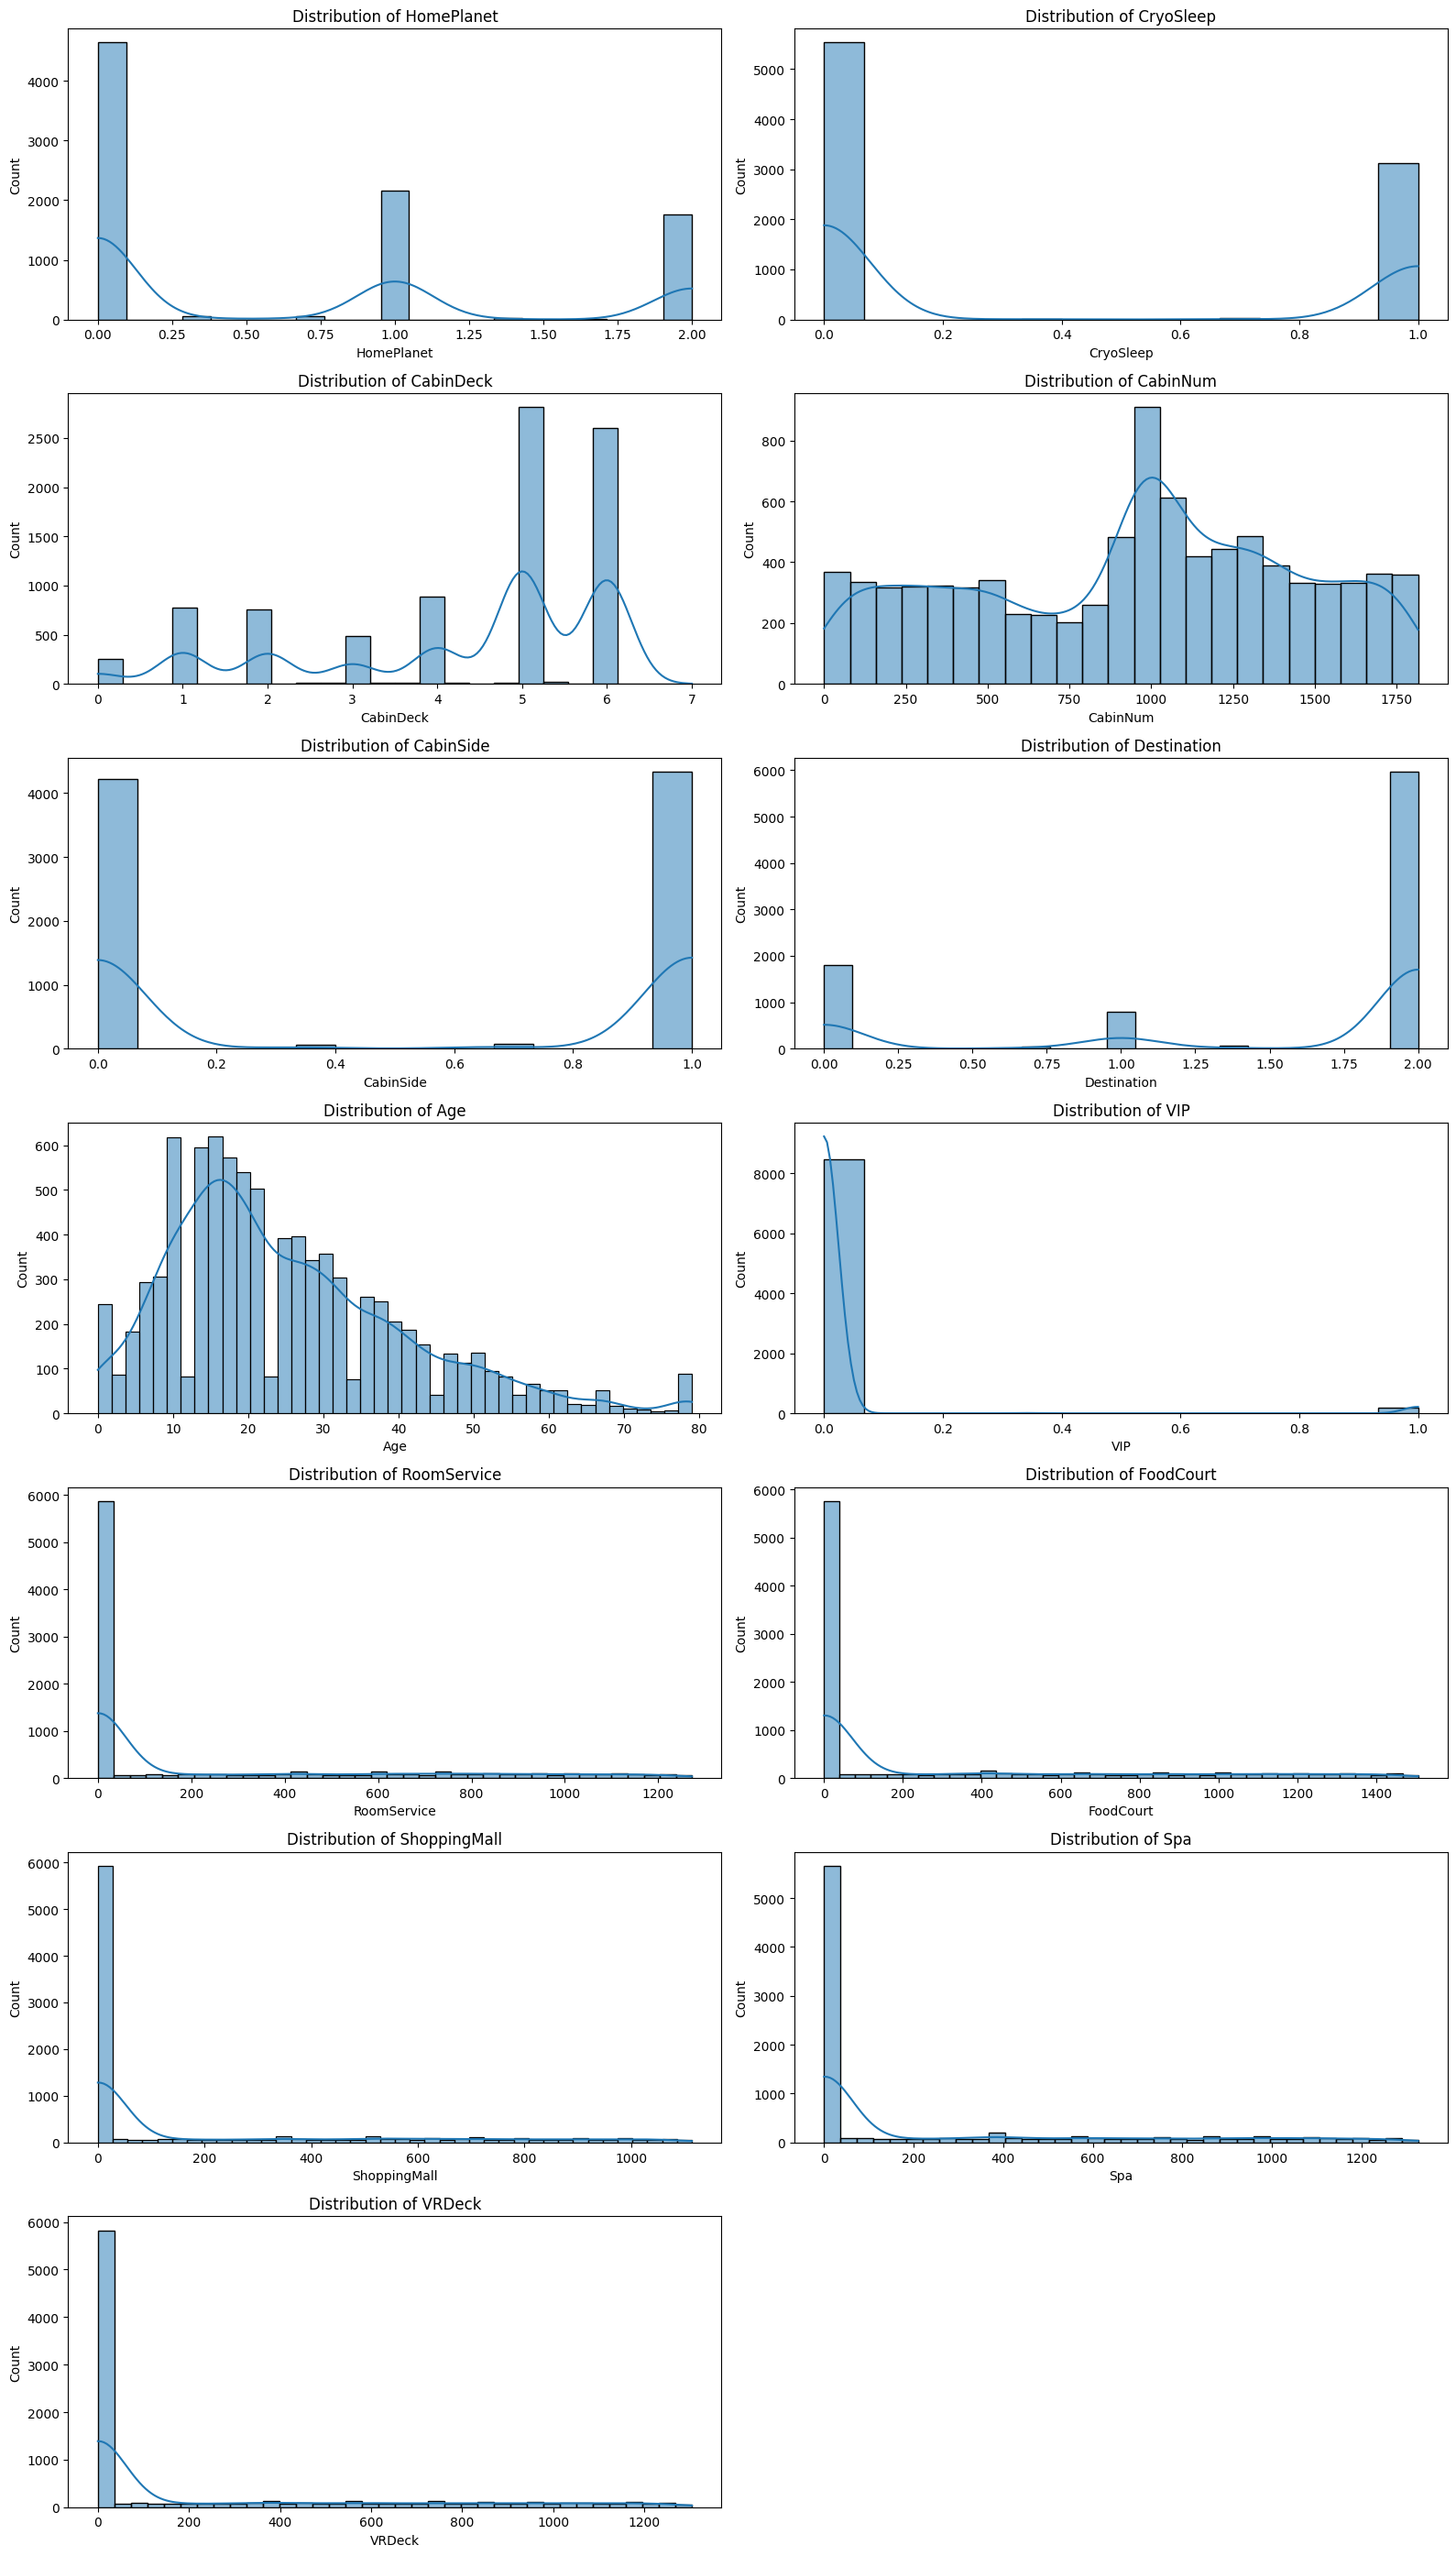

In [170]:
num_cols = len(numeric_features)

num_rows = num_cols // 2 if num_cols % 2 == 0 else (num_cols // 2) + 1
num_cols = 2

plt.figure(figsize=(16, num_rows * 4))

for index, column in enumerate(numeric_features):
    plt.subplot(num_rows, num_cols, index + 1)
    sns.histplot(df[column], kde = True)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

In [ ]:
# Box-Cox transformation of highty skewed features
from scipy import stats

skewed_features = ['VRDeck', 'Spa', 'ShoppingMall', 'FoodCourt', 'RoomService']

for col in skewed_features:
    min_positive_value = np.min(df[col][df[col] > 0])
    shift_constant = min_positive_value / 2
    data_shifted = np.where(data <= 0, df[col] + shift_constant, df[col])
    transformed_data, lambda_value = stats.boxcox(data_shifted)
